In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joiningFunctions as jf
from matplotlib.legend_handler import HandlerLine2D
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

%matplotlib inline

ModuleNotFoundError: No module named 'numpy'

In [2]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
submit1_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv',index_col=0)
submit2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test3.csv')
nypd_complaints = pd.read_csv('2018_NYPD_Complaints.csv', index_col=0)
zip_incident =  pd.read_csv('zip_incident_df.csv',index_col=0)

In [3]:
train_df = jf.joinRentNYPD(train_df, nypd_complaints)
train_df = jf.jointRent311(train_df, zip_incident)

test_df = jf.joinRentNYPD(test_df, nypd_complaints)
test_df = jf.jointRent311(test_df, zip_incident)

submit1_df = jf.joinRentNYPD(submit1_df, nypd_complaints)
submit1_df = jf.jointRent311(submit1_df, zip_incident)

submit2_df = jf.joinRentNYPD(submit2_df, nypd_complaints)
submit2_df = jf.jointRent311(submit2_df, zip_incident)

train_df.columns

Index(['addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft',
       'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat',
       'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway',
       'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher',
       'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer',
       'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
       'has_childrens_playroom', 'rent', 'no_fee', 'description',
       'neighborhood', 'borough', 'unit', 'floornumber', 'line', 'precinct',
       'petit_larceny', 'harrassment_2', 'assault_3', 'criminal_mischief',
       'grand_larceny', 'public_order', 'felony_assault', 'dangerous_drugs',
       'penal_law', 'robbery', 'burglary', 'misdemenor', 'felony', 'violation',
       'Number of Incidents'],
      dtype='object')

In [4]:
train_df.shape

(12000, 54)

In [5]:
test_df.shape

(2000, 54)

In [6]:
train_df.sample(5).transpose()

,5347,7328,9773,7149,3235
addr_unit,#203,#1W,#1,#2C,#2D
building_id,54661,105916,1266391,34648,796354
bedrooms,0,3,2,0,2
bathrooms,1,2,1,1,1
size_sqft,300,1400,1200,550,900
created_at,2018-05-26 14:02:09,2018-06-14 19:01:11,2018-06-03 17:21:49,2018-05-11 12:33:57,2018-07-24 13:02:48
addr_street,457 WEST 57 STREET,205 WEST 107 STREET,33-05 28 AVENUE,85 8 AVENUE,2612 WEST 2 STREET
addr_city,New York,New York,Astoria,New York,Brooklyn
addr_zip,10019,10025,11103,10011,11223
addr_lat,40.769,40.8016,40.7678,40.7403,40.5849


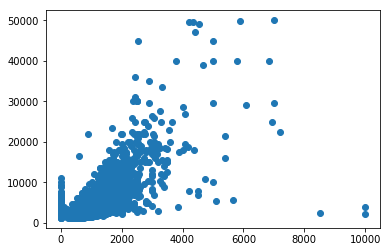

In [7]:
plt.scatter(train_df['size_sqft'],train_df['rent'])

In [8]:
#Had to remove features with strings as the type i.e. 'addr_city', 'neighborhood', 'borough'
#Might have to try turning them into numbers to find out how important they are
features = ['bedrooms', 'bathrooms', 'size_sqft', 'addr_zip', 'bin', 'bbl',
                    'floor_count', 'has_doorman', 'has_elevator',
                    'has_fireplace', 'has_dishwasher','is_furnished', 'has_gym', 'allows_pets',
                    'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool',
                    'precinct', 'petit_larceny', 'harrassment_2', 'assault_3', 'criminal_mischief',
                    'grand_larceny', 'public_order', 'felony_assault', 'dangerous_drugs', 'penal_law',
                    'robbery', 'burglary', 'misdemenor', 'felony', 'violation', 'has_garden', 
                    'has_childrens_playroom', 'Number of Incidents', 'no_fee', 'rent']


#Most important features (comment it out to test every feature)
# features = ['size_sqft', 'bbl', 'bathrooms', 'bedrooms', 'rent']

print('Train NaNs:', train_df[features].isna().sum(), sep='\n')
print('\n')
print('Test NaNs:', test_df[features].isna().sum(), sep='\n')

train_features = train_df[features].dropna()
train_target = train_features['rent']
train_features = train_features.drop(labels='rent', axis=1)
test_features = test_df[features]
test_target = test_features['rent']
test_features = test_features.drop(labels='rent', axis=1)

Train NaNs:
bedrooms                  0
bathrooms                 0
size_sqft                 0
addr_zip                  0
bin                       1
bbl                       0
floor_count               0
has_doorman               0
has_elevator              0
has_fireplace             0
has_dishwasher            0
is_furnished              0
has_gym                   0
allows_pets               0
has_washer_dryer          0
has_garage                0
has_roofdeck              0
has_concierge             0
has_pool                  0
precinct                  0
petit_larceny             0
harrassment_2             0
assault_3                 0
criminal_mischief         0
grand_larceny             0
public_order              0
felony_assault            0
dangerous_drugs           0
penal_law                 0
robbery                   0
burglary                  0
misdemenor                0
felony                    0
violation                 0
has_garden                0
has_chil

In [9]:
# Checking if there are any missing values for the features in the test2.csv set
print('test2.csv NaNs:', submit1_df[features].isna().sum(), sep='\n')

test2.csv NaNs:
bedrooms                     0
bathrooms                    0
size_sqft                    0
addr_zip                     0
bin                          0
bbl                          0
floor_count                  0
has_doorman                  0
has_elevator                 0
has_fireplace                0
has_dishwasher               0
is_furnished                 0
has_gym                      0
allows_pets                  0
has_washer_dryer             0
has_garage                   0
has_roofdeck                 0
has_concierge                0
has_pool                     0
precinct                     0
petit_larceny                0
harrassment_2                0
assault_3                    0
criminal_mischief            0
grand_larceny                0
public_order                 0
felony_assault               0
dangerous_drugs              0
penal_law                    0
robbery                      0
burglary                     0
misdemenor             

In [10]:
# Checking if there are any missing values for the features in the test2.csv set
print('test3.csv NaNs:', submit2_df[features].isna().sum(), sep='\n')

test3.csv NaNs:
bedrooms                     0
bathrooms                    0
size_sqft                    0
addr_zip                     0
bin                          2
bbl                          0
floor_count                  0
has_doorman                  0
has_elevator                 0
has_fireplace                0
has_dishwasher               0
is_furnished                 0
has_gym                      0
allows_pets                  0
has_washer_dryer             0
has_garage                   0
has_roofdeck                 0
has_concierge                0
has_pool                     0
precinct                     0
petit_larceny                0
harrassment_2                0
assault_3                    0
criminal_mischief            0
grand_larceny                0
public_order                 0
felony_assault               0
dangerous_drugs              0
penal_law                    0
robbery                      0
burglary                     0
misdemenor             

In [11]:
submit2_features = submit2_df[features].drop(labels='rent', axis=1)
submit2_features.isnull().sum().sum()

2

In [12]:
submit2_features['bin'].fillna(1000000.0, inplace = True)

In [13]:
submit2_features.isnull().sum().sum()

0

In [14]:
# Checking if there is anymore null values
submit2_features[submit2_features['bin'].isnull()]

,bedrooms,bathrooms,size_sqft,addr_zip,bin,bbl,floor_count,has_doorman,has_elevator,has_fireplace,...,penal_law,robbery,burglary,misdemenor,felony,violation,has_garden,has_childrens_playroom,Number of Incidents,no_fee


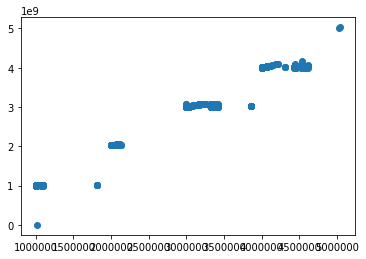

In [15]:
plt.scatter(test_df['bin'],test_df['bbl'])

In [16]:
#zip codes missing from the join function will go back and add these.
print(test_features.loc[test_features.precinct.isna(), 'addr_zip'])
print(submit1_df.loc[submit1_df.precinct.isna(), 'addr_zip'])
print(submit2_df.loc[submit2_df.precinct.isna(), 'addr_zip'])

Series([], Name: addr_zip, dtype: int64)
Series([], Name: addr_zip, dtype: int64)
Series([], Name: addr_zip, dtype: int64)


In [17]:
# fits estimator to training set and predicts on test1.csv features
# prints out MSE of predictions against test1.csv
# also calculates and prints std dev & mean of 5-fold CV  on training set
def getResults(estimator):
    estimator.fit(train_features, train_target)
    test_pred = estimator.predict(test_features)
    cv_results = cross_val_score(estimator, train_features, train_target, cv=5, scoring='neg_mean_squared_error')
    print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
    print("CV Results (Std Dev): ", np.std(cv_results))
    print("CV Results (Mean): ", np.mean(cv_results))

#To get the feature importances for linear regression scale the features and then use .coef_
#importances for lr are in magnitude while others are in percentage
#I haven't scaled the features so this code doesn't really tell you much
def getSortedImportances(estimator):
    temp = {}
    importances = estimator.coef_ if isinstance(estimator, LinearRegression) else estimator.feature_importances_*100
    print('\nFeature Importances')
    for i in range(len(importances)):
        temp[features[i]] = importances[i]
    
    sorted_temp = sorted(temp, key=temp.get)
    for feat in sorted_temp:
        print(feat, temp[feat])

In [18]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
gb = GradientBoostingRegressor()
rf = RandomForestRegressor()

names = ['\nLinear Regression', '\nDecision Tree Regressor', '\nGradient Boosting Regressor', '\nRandom Forest Regressor']
estimators = [lr, dt, gb, rf]

for i in range(len(names)):
    print(names[i])
    getResults(estimators[i])
    getSortedImportances(estimators[i])


Linear Regression
Mean Squared Error:  3180974.0326844463
CV Results (Std Dev):  679827.0580970801
CV Results (Mean):  -3074207.55587814

Feature Importances
has_dishwasher -201.45611949343274
no_fee -184.70792652842988
has_garage -177.36064178166615
violation -7.46239735702213
criminal_mischief -4.007469564017826
floor_count -3.427966302531502
dangerous_drugs -3.2369487207513443
public_order -2.7084714721029584
petit_larceny -2.6198189200700637
felony_assault -2.282409163731417
assault_3 -1.9701966918918834
precinct -0.5890077464422859
addr_zip -0.45133221166897275
grand_larceny -0.09614679657128693
Number of Incidents -0.032036360523561916
bbl -4.5001237797347044e-07
bin 0.00016881680914659862
felony 0.4637800835418419
robbery 0.8026771959146077
burglary 1.5190590925068435
size_sqft 2.317322010644784
misdemenor 2.8852000577551626
penal_law 4.310844142614586
harrassment_2 6.175463681200045
has_garden 41.90215589665782
has_doorman 73.55686333201551
has_childrens_playroom 107.328289981

GradientBoostingRegressor or RandomForestRegressor seems to give us the best score so far, further testing with hyperparameters is needed

In [19]:
def testHyperparameter(param_grid):
    results = {}
    hp_name = list(param_grid.keys())[0]
    hp_values = list(param_grid.values())[0]
    
    # Create decision tree model and tune hyperparameter using GridSearchCV
    decision_tree = DecisionTreeRegressor()
    dt_cv = GridSearchCV(dt, param_grid, cv=5)
    dt_cv.fit(train_features, train_target)
    results['best_param'] = dt_cv.best_params_
    results['best_score'] = dt_cv.best_score_
    
    # Grab mean test/train score of 5 splits
    mean_test = dt_cv.cv_results_['mean_test_score']
    mean_train = dt_cv.cv_results_['mean_train_score']

    # Plot mean test/train AUC score against hyperparameter values
    line1, = plt.plot(hp_values, mean_test, 'b', label='Test AUC')
    line2, = plt.plot(hp_values, mean_train, 'r', label='Train AUC')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC Score')
    plt.xlabel(hp_name)
    plt.show()
    
    print(results)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


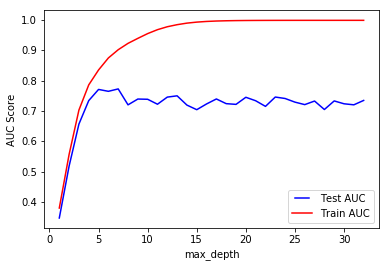

{'best_param': {'max_depth': 7}, 'best_score': 0.7722961918690597}


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


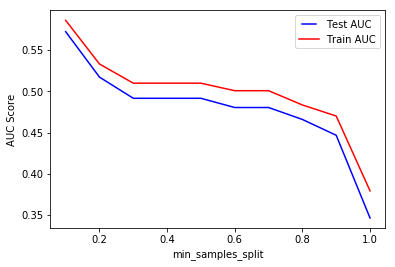

{'best_param': {'min_samples_split': 0.1}, 'best_score': 0.5724558715766266}


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


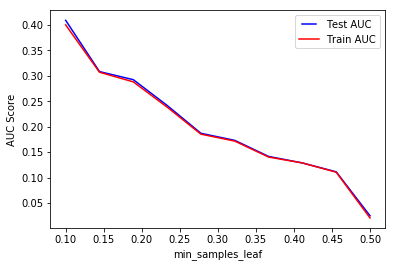

{'best_param': {'min_samples_leaf': 0.1}, 'best_score': 0.4093181603119941}


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


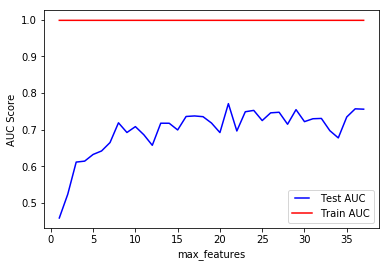

{'best_param': {'max_features': 21}, 'best_score': 0.7709948963361108}


In [20]:
# Tuning individual hyperparameters for decision tree regressor 
param_grids = []

# Hyperparameter 1: max_depth -> indicates depth of tree; 
# Testing range of 1 to 32
max_depth_values = np.arange(1, 33)
param_grids.append({'max_depth': max_depth_values})

# Hyperparameter 2: min_samples_split <- minimum number of samples required to split a node
# Testing range from 10% to 100%
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
param_grids.append({'min_samples_split': min_samples_split})

# Hyperparameter 3: min_samples_leaf <- minimum number of samples required at each leaf node
# Testing range from 10% to 50%
min_samples_leaf = np.linspace(0.1, 0.5, 10, endpoint=True)
param_grids.append({'min_samples_leaf': min_samples_leaf})

# Hyperparameter 4: max_features <- max number of features to test
# Testing range from 1 to 1 less than the number of features in the df
max_features = list(range(1,train_features.shape[1]))
param_grids.append({'max_features': max_features})

for hyperparameter in param_grids:
    testHyperparameter(hyperparameter)


In [21]:
# Testing all 4 hyperparameters together to find the best combination
param_grid = {
              "min_samples_split": [10, 20, 40, 80, 160],
              "max_depth": [2, 6, 8, 10, 15, 20, 30, 40, 50],
              "min_samples_leaf": [20, 40, 100, 200, 400],
              "max_leaf_nodes": [5, 20, 100, 200, 500]
              }

dtr = DecisionTreeRegressor()
dtr_cv = RandomizedSearchCV(dtr, param_grid, cv=5, n_iter = 1000, n_jobs=-1)
dtr_cv.fit(train_features, train_target)
print(dtr_cv.best_params_)
print(dtr_cv.best_score_)
print(dtr_cv.best_estimator_)

{'min_samples_split': 40, 'min_samples_leaf': 20, 'max_leaf_nodes': 500, 'max_depth': 15}
0.7725451228404697
DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
           max_leaf_nodes=500, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=40, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


In [22]:
# Results of predicting rent on test set using optimized decision tree
optimized_dt = dtr_cv.best_estimator_
test_pred = optimized_dt.predict(test_features)
cv_results = cross_val_score(optimized_dt, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('DecisionTreeRegressor')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

DecisionTreeRegressor
Mean Squared Error:  2507707.486739548
CV Results:  [-2075580.4340948  -1979068.06881676 -2353347.85778853 -1512113.90860032
 -1498022.4125161 ]
Mean CV Results:  -1883626.5363633025


In [23]:
rf = RandomForestRegressor(random_state = 42)

# not too important to care about. just wanted to see parameters inside
from pprint import pprint

pprint(rf.get_params())

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [24]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 32]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8, 16, 32],
 'min_samples_split': [2, 5, 10, 20, 50],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [25]:
#Random Search Training
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50,
                              cv = 5, random_state = 42, n_jobs = -1)

rf_random.fit(train_features, train_target)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 50], 'min_samples_leaf': [1, 2, 4, 8, 16, 32], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [26]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

Now testing optimized random forest

In [27]:
optimized_rf =  rf_random.best_estimator_
test_pred = optimized_rf.predict(test_features)
cv_results = cross_val_score(optimized_rf, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

#Mean Squared Error slightly decreases.

Mean Squared Error:  1586388.552746519
CV Results:  [-1515635.88055833  -856575.90502244 -1332955.32332935 -1104392.99107467
  -569955.98110241]
Mean CV Results:  -1075903.2162174385


In [28]:
test_pred

array([ 2581.231     ,  2115.0815    ,  2933.0955    , ...,
       14966.431     ,  3594.32      ,  2835.44166667])

In [29]:
test_rental_id = test_df.iloc[:,0]
print(test_rental_id)

0           #1B
1           #C4
2       #GARDEN
3           #2C
4            #9
5        #APT3F
6           NaN
7          #33C
8           #18
9           #C1
10      3-FLOOR
11           #7
12          #2L
13          #2K
14           #2
15          #15
16         #417
17        #104B
18           #A
19          #4A
20          #2B
21           #2
22         #11E
23      #PARLOR
24         #44B
25          #2B
26          #2L
27          #7O
28           #1
29          #8E
         ...   
1970       #204
1971       #C32
1972       #35E
1973        #10
1974       #PHD
1975        #3E
1976         #2
1977       #C47
1978       #E13
1979       #10D
1980        #4F
1981        #2D
1982        #A2
1983        #8A
1984        #4B
1985        #4C
1986        #5N
1987        #3A
1988        #1E
1989         #B
1990         #2
1991      #305R
1992       #12R
1993         #3
1994       #5CC
1995        #4H
1996       #11K
1997       #44A
1998       #15M
1999         #3
Name: addr_unit, Length:

In [30]:
# checking for any missing values in test3.csv
submit2_features.isnull().sum().sum()

0

In [31]:
submit2_features[submit2_features['bin'].isnull()]

,bedrooms,bathrooms,size_sqft,addr_zip,bin,bbl,floor_count,has_doorman,has_elevator,has_fireplace,...,penal_law,robbery,burglary,misdemenor,felony,violation,has_garden,has_childrens_playroom,Number of Incidents,no_fee


In [32]:
print(optimized_rf.score(train_features, train_target))

0.9982678928817742


In [33]:
# Create submission file for test2.csv (Commented out so the .csv doesn't get overwritten)
#submit1_df['predictions'] = optimized_rf.predict(submit1_features)
#submit1_df['predictions'].to_csv('test2_submission.csv', header=True)

In [35]:
# Checking feature importance for optimized random forest
getSortedImportances(optimized_rf)


Feature Importances
has_garage 0.2153304136345354
has_childrens_playroom 0.3725145304882332
has_fireplace 0.3789807657723587
has_pool 0.3838676309700689
felony 0.3897722199052764
violation 0.3917118870754302
allows_pets 0.42033965236748566
public_order 0.42318352570528667
harrassment_2 0.4365809812373735
misdemenor 0.4391827265023043
burglary 0.4426351576167055
assault_3 0.5212522872866683
dangerous_drugs 0.5837657386867624
has_roofdeck 0.5955063951093197
is_furnished 0.612865108007962
petit_larceny 0.6347341903296592
robbery 0.6770552218628959
has_garden 0.6829348194696155
has_concierge 0.7098265664979364
has_elevator 0.7201213878638648
has_gym 0.731717102695665
has_doorman 0.7444095630821115
felony_assault 0.7505653270032535
has_dishwasher 0.8842519764552331
criminal_mischief 0.8855583111263523
no_fee 1.0129609782538544
Number of Incidents 1.3978557853999294
grand_larceny 1.4118870467704607
penal_law 1.6553284684070955
floor_count 2.5117456908884606
addr_zip 3.1219921771479586
preci

In [36]:
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

# not too important to care about. just wanted to see parameters inside
from pprint import pprint

pprint(gb.get_params())

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}


In [37]:
# Testing generic gradient boosting regressor again
gb.fit(train_features, train_target)
test_pred = gb.predict(test_features)
cv_results = cross_val_score(gb, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

Mean Squared Error:  1754816.4661056257
CV Results:  [-1311875.49959971 -1129005.24136111 -1471949.9249243  -1228566.8290144
  -721664.13634098]
Mean CV Results:  -1172612.3262480982


In [38]:
# Using the R-squared value allows us to see how much of the variance in the data our model is explains.
print("R-squared for Train: %.2f" %gb.score(train_features, train_target))
print("R-squared for Test: %.2f" %gb.score(test_features, test_target))

R-squared for Train: 0.91
R-squared for Test: 0.76


In [39]:
# Number of trees to be modeled 
n_estimators = [100, 200, 300, 400, 500]
    
# Number of features to consider when searching for a best split
max_features = [1.0, 0.5, 0.3, 0.1, 0.01, 0.001]

# Represents the impact of each tree 
learning_rate = [0.1, 0.05, 0.02, 0.01]
    
# Maximum number of levels in tree
max_depth = [2, 4, 6, 8, 10]
    
# Minimum number of samples required at each leaf node
min_samples_leaf = [3, 5, 7, 9, 15, 20]
    
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'learning_rate': [0.1, 0.05, 0.02, 0.01],
 'max_depth': [2, 4, 6, 8, 10],
 'max_features': [1.0, 0.5, 0.3, 0.1, 0.01, 0.001],
 'min_samples_leaf': [3, 5, 7, 9, 15, 20],
 'n_estimators': [100, 200, 300, 400, 500]}


In [40]:
# Random Search Training for Gradient Boosting 
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 50,
                              cv = 5, random_state = 42, n_jobs = -1)

gb_random.fit(train_features, train_target)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500], 'max_features': [1.0, 0.5, 0.3, 0.1, 0.01, 0.001], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_leaf': [3, 5, 7, 9, 15, 20]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [41]:
gb_random.best_params_

{'n_estimators': 500,
 'min_samples_leaf': 9,
 'max_features': 0.3,
 'max_depth': 6,
 'learning_rate': 0.1}

In [42]:
optimized_gb =  gb_random.best_estimator_
test_pred = optimized_gb.predict(test_features)
cv_results = cross_val_score(optimized_gb, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

Mean Squared Error:  1547240.4759733272
CV Results:  [-1181686.11558674  -854826.85204851 -1233221.31690111  -936689.74052743
  -631818.60970598]
Mean CV Results:  -967648.526953953


In [43]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
optimized_dt = dtr_cv.best_estimator_
optimized_gb =  gb_random.best_estimator_

estimators = [lr, dt, rf, gb, optimized_dt, optimized_gb]

train_r2 = []
test_r2 = []

def getRSquared(estimator):
    estimator.fit(train_features, train_target)
    test_pred = estimator.predict(test_features)
    train_cv_results = cross_val_score(estimator, train_features, train_target, cv=5, scoring = 'r2')
    test_cv_results = cross_val_score(estimator, test_features, test_pred, cv=5, scoring = 'r2')
    train_r2.append(np.mean(train_cv_results))
    test_r2.append(np.mean(test_cv_results))

In [44]:
for estimator in estimators:
    getRSquared(estimator)

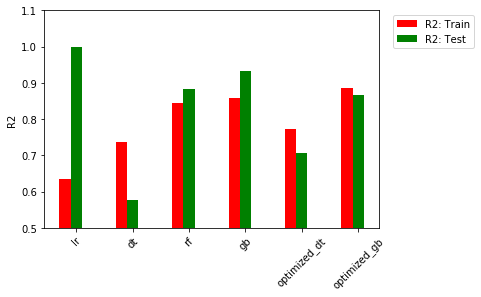

In [45]:
n = 6
ind = np.arange(n)  # the x locations for the groups
width = 0.2       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

train_rect = ax.bar(ind, train_r2, width, color='r')
test_rect = ax.bar(ind+width, test_r2, width, color='g')

ax.set_ylabel('R2')
ax.set_xticks(ind+width)
ax.set_xticklabels( ['lr', 'dt', 'rf', 'gb', 'optimized_dt', 'optimized_gb'], rotation=45 )
ax.legend( (train_rect[0], test_rect[0]), ('R2: Train', 'R2: Test'), loc=1, bbox_to_anchor=(0.5, 0.5, 0.8, 0.5) )
plt.ylim((0.5,1.1))

plt.show()

In [46]:
# Create submission file for test3.csv (Commented out so the .csv doesn't get overwritten)
submit2_df['predictions'] = optimized_gb.predict(submit2_features)
submit2_df[['rental_id','predictions']].to_csv('test3_submission.csv', header=True, index=False)

In [47]:
getSortedImportances(optimized_gb)


Feature Importances
has_childrens_playroom 0.46338326018753595
has_pool 0.5764648859907043
has_fireplace 0.630206121980602
has_garage 0.6304249637482731
is_furnished 0.651086865684034
has_elevator 0.6785669480279495
has_doorman 0.7705258303842691
robbery 0.8068822315993273
misdemenor 0.8111520665620943
felony_assault 0.8342875372176317
petit_larceny 0.8419761057954355
assault_3 0.8538421500381486
allows_pets 0.8884374274190501
harrassment_2 0.9173813322806842
penal_law 0.9217437896691488
has_gym 0.9503187055596816
burglary 0.9831390811092676
felony 1.0247958905674284
no_fee 1.0267853521196195
has_roofdeck 1.083199228176367
violation 1.0902987370554342
has_garden 1.1615862561741523
has_concierge 1.1746446956321916
has_dishwasher 1.1782604304676556
criminal_mischief 1.2685536063549725
grand_larceny 1.3301005197524194
dangerous_drugs 1.3395680322722623
has_washer_dryer 1.356728008571478
public_order 1.4003360290096136
precinct 1.6861554113933772
Number of Incidents 3.25221492183399
addr_